In [1]:
import matplotlib.pyplot as plt
import glob
import re
import os
import sys
from Bio import PDB
from Bio.PDB.PDBIO import PDBIO
from Bio.PDB.StructureBuilder import StructureBuilder
import MDAnalysis as mda
import numpy as np

/opt/homebrew/anaconda3/envs/IPL-workshop/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### First convert AF3 models from CIF to PDB

In [2]:
# AF3 models are stored in AF3_models directory as cif files
AF3_models=glob.glob("AF3_models*/*.cif")
# convert to PDB
for f in AF3_models:
    # get PDB file name
    fpdb=re.sub(".cif",".pdb",f)
    # convert to PDB
    parser = PDB.MMCIFParser()
    structure = parser.get_structure(structure_id="PDB", filename=f)
    io=PDBIO()
    io.set_structure(structure)
    io.save(fpdb)

### run FoldX on AF3 models

In [ ]:
sys._jupyter_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w') # block prints to avoid overflow of lines in our jupyter notebook
#
# location of foldx binary
foldx_="/Users/max/bin/foldx5_1Mac_0/foldx_20241231"
#
# extract binding energy from FoldX output
def get_binding(m, f):
    for lines in open(f, "r").readlines():
        r = lines.strip().split()
        if(len(r)>0 and r[0]==m): be = float(r[5])
    return be

# binding energy dictionary
be = {}
# AF3 models in pdb FORMAT
AF3_models=glob.glob("AF3_models*/*.pdb")
# run FoldX
for m in AF3_models:
    # get directory
    d = m.split("/")[0]
    # get filename
    f = m.split("/")[1]
    # repair PDB to fix clashes
    os.system(foldx_+" --command=RepairPDB --pdb="+f+" --pdb-dir="+d+" --output-dir="+d)
    # name of repaired pdb
    f =re.sub(".pdb","_Repair.pdb",f)
    # run command- assuming viral protein chain A, antibody chain B and C
    os.system(foldx_+" --command=AnalyseComplex --pdb="+f+" --analyseComplexChains=A,BC --complexWithDNA=false --output-file=foldX_out clean-mode --pdb-dir="+d+" --output-dir="+d)   
    # extract binding energy
    be[m] = get_binding(d+"/"+f, d+"/Summary_foldX_out_AC.fxout")
    break
#
sys.stdout = sys._jupyter_stdout #sys.__stdout__ # reenable prints
print(be)

   ********************************************
   ***                                      ***
   ***             FoldX 5.1 (c)            ***
   ***                                      ***
   ***     code by the FoldX Consortium     ***
   ***                                      ***
   ***     Jesper Borg, Frederic Rousseau   ***
   ***    Joost Schymkowitz, Luis Serrano   ***
   ***    Peter Vanhee, Erik Verschueren    ***
   ***     Lies Baeten, Javier Delgado      ***
   ***       and Francois Stricher          ***
   *** and any other of the 9! permutations ***
   ***   based on an original concept by    ***
   ***   Raphael Guerois and Luis Serrano   ***
   ********************************************

Start RepairPDB >>>

1 models read: fold_banal_7cwl_model_2.pdb
Repair will take all residues into account
wild type

BackHbond       =               -931.72
SideHbond       =               -238.23
Energy_VdW      =               -1436.35
Electro         =               -54.64
E

### Bar plot with binding energy

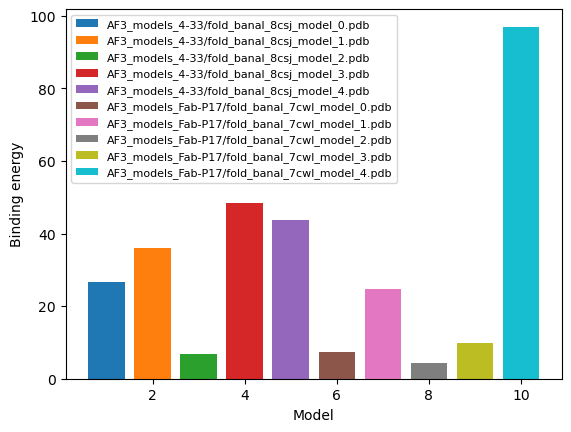

In [23]:
# make bar plot
fig, ax = plt.subplots()
# loop over models
for i,m in enumerate(sorted(AF3_models)):
    ax.bar([i+1], [be[m]], label=m)
# set labels
ax.set_xlabel('Model')
ax.set_ylabel('Binding energy')
ax.legend(loc="upper left", fontsize=8, ncol=1)
plt.show()